In [30]:
%matplotlib inline
import matplotlib.pylab as pylab
import matplotlib.lines as mlines

import pymc as mc

import pandas as pd
import numpy as np

import datetime

In [31]:
import vpfits

# VPfits

The VPfits module contains a class, `VPfit`, that carries out most of the heavy lifting. First we create an instance of this class.

In [32]:
vpfit = vpfits.VPfit()

## Mock Spectra

`VPfit` contains a function for creating mock absoprtion profiles, `mock_absorption`. Just tell it how many features you wish to include. It returns a dataframe, `clouds`, containing each feature, and an array of wavelength values. It can also plot the profile.

If you wish to create mock voigt profiles, set the `voigt` parameter to true.

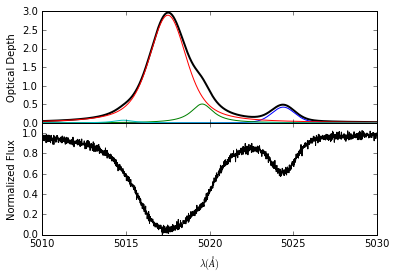

In [66]:
n = 4

#clouds, wavelength_array = vpfits.mock_absorption(n=n, plot=True, saturated=True)

clouds, wavelength_array = vpfits.mock_absorption(n=n, plot=True, saturated=True, voigt=True)

The plot shows the profile with added noise, but right now the function doesn't return this composite noisy profile, so we recreate it as `flux_array`.

In [51]:
onesigmaerror = 0.02
noise = np.random.normal(0.0, onesigmaerror, len(wavelength_array))

noise_vector = [onesigmaerror]*len(noise)
flux_array = vpfit.Absorption(sum(clouds['tau'])) + noise

## Fitting

To fit, initialise the model with `n` profiles, calculate the MAP estimate, then run the MCMC.

If you wish to fit Voigt profiles, set the `voigt` flag to True (be aware that the VPfit Voigt profile implementation consists of an extra parameter relative to the Gaussian, and will take longer to converge, especially for complicated profiles).

In [56]:
#vpfit.initialise_model(wavelength_array, flux_array, n)

vpfit.initialise_model(wavelength_array, flux_array, n, voigt=True)

Initialising Voigt profile components.


In [57]:
vpfit.map_estimate()

In [58]:
vpfit.mcmc_fit(iterations=10000, burnin=5000)

Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 119.4 sec
Took: 0:01:59.401279  to finish.


Our `VPfit` instance, `vpfit`, now contains the fitted profile components.

## Convergence

We can assess whether the chain has converged using a number of different formal diagnostics provided by PyMC. 

*The Geweke diagnostic often fails with an opaque error, especially if the chains are very far from convergence.*

In [59]:
alpha_scores = mc.geweke(vpfit.mcmc, intervals=20)

mc.Matplot.geweke_plot(alpha_scores)

LinAlgError: Singular matrix

In [60]:
rl_convergence = mc.raftery_lewis(vpfit.mcmc, q=0.995, r=0.05, verbose=True)
rl_convergence


Diagnostic for est_centroid_3 ...

Raftery-Lewis Diagnostic

8 iterations required (assuming independence) to achieve 0.05 accuracy with 95 percent probability.

Thinning factor of 1 required to produce a first-order Markov chain.

-2147483648 iterations to be discarded at the beginning of the simulation (burn-in).

-2147483648 subsequent iterations required.

Thinning factor of 1 required to produce an independence chain.

Diagnostic for est_centroid_2 ...

Raftery-Lewis Diagnostic

8 iterations required (assuming independence) to achieve 0.05 accuracy with 95 percent probability.

Thinning factor of 1 required to produce a first-order Markov chain.

-2147483648 iterations to be discarded at the beginning of the simulation (burn-in).

-2147483648 subsequent iterations required.

Thinning factor of 1 required to produce an independence chain.

Diagnostic for est_L_1 ...

Raftery-Lewis Diagnostic

8 iterations required (assuming independence) to achieve 0.05 accuracy with 95 percent pr

{'est_G_0': (8, 2, 26, 64, 4),
 'est_G_1': (8, 1, 13, 16, 4),
 'est_G_2': (8, 1, 17, 28, 3),
 'est_G_3': (8, 1, 1, 1, 1),
 'est_L_0': (8, 1, 38, 81, 8),
 'est_L_1': (8, 1, 27, 61, 7),
 'est_L_2': (8, 1, 9, 15, 2),
 'est_L_3': (8, 1, 59, 94, 7),
 'est_centroid_0': (8, 1, 45, 1, 7),
 'est_centroid_1': (8, 1, -2147483648, -2147483648, 1),
 'est_centroid_2': (8, 1, -2147483648, -2147483648, 1),
 'est_centroid_3': (8, 1, -2147483648, -2147483648, 1),
 'sd': (8, 1, 17, 28, 3),
 'xexp_0': (8, 1, 45, 1, 7),
 'xexp_1': (8, 1, 24, 52, 4),
 'xexp_2': (8, 1, 24, 52, 4),
 'xexp_3': (8, 1, 31, 55, 6)}

## Model Selection

We can query some features of the fit useful for model selection, such as the Maximum A Posteriori (MAP) Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC).

In [61]:
print vpfit.MAP.BIC
print vpfit.MAP.AIC

-7634.65173542
-7729.86707723


We also have model selection metrics from the MCMC

In [62]:
print vpfit.mcmc.BPIC
print vpfit.mcmc.DIC

-10070.6045975
-10045.9888326


The class instance also has functions for calculating both the $\chi^2$ and the reduced chi-squared, $\chi_{r}^{2}$.

In [63]:
vpfits.VPfit.Chisquared(vpfit.total.value, flux_array)

1.5370103716699024

In [64]:
vpfits.VPfit.ReducedChisquared(vpfit.total.value, flux_array, len(vpfit.estimated_variables))

0.00077004527638772663

## Plotting

Finally, we can also plot the fit, with residuals. The fitted components and actual components can be directly compared.

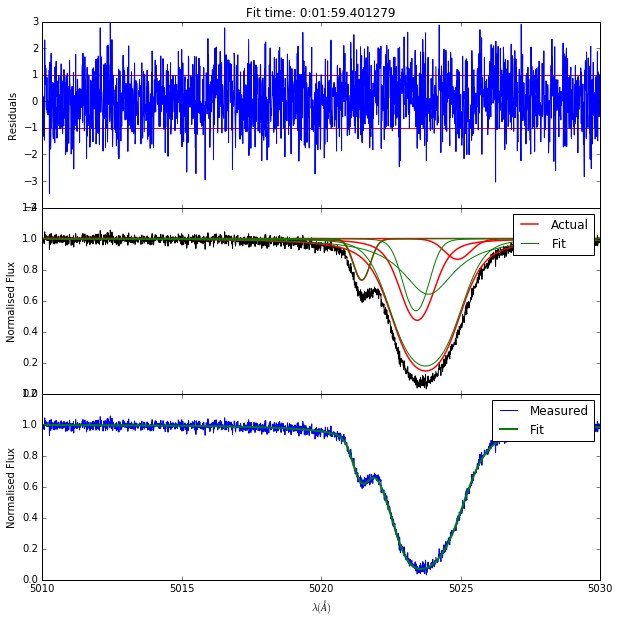

In [65]:
vpfit.plot(wavelength_array, flux_array, clouds, n=n)

# Region Detection

Regions are detected based on a detection threshold of 4 sigma. The number of pixels needed below the threshold to divide regions is set with `buffer`, and the minimum width of a region is set with `min_region_width` in pixels.

The `compute_detection_regions` function outputs a numpy array of the start and end wavelengths of each region.

In [78]:
min_region_width = 3
regions = vpfits.compute_detection_regions(wavelength_array, flux_array, noise_vector, 
                                           min_region_width = min_region_width)

print regions

Computing detection regions...
Found 4 detection regions.
[[ 5010.02  5016.27]
 [ 5016.21  5016.45]
 [ 5020.22  5027.01]
 [ 5027.16  5027.39]]


We then construct arrays containing the delimiting pixels and wavelength values for each region

In [74]:
region_arrays = []
region_pixels = []

for region in regions:
    
    start = np.where(wavelength_array==region[0])[0][0]
    end = np.where(wavelength_array==region[1])[0][0]
    
    region_pixels.append([start, end])
    region_arrays.append([wavelength_array[start:end], flux_array[start:end]])

We can now plot each region.

In [75]:
def plot_bracket(x, dir):
    height = .2
    arm_length = 0.2
    pylab.plot((x, x), (1-height/2, 1+height/2), color='magenta')
    if dir=='left':
        xarm = x+arm_length
    if dir=='right':
        xarm = x-arm_length
    pylab.plot((x, xarm), (1-height/2, 1-height/2), color='magenta')
    pylab.plot((x, xarm), (1+height/2, 1+height/2), color='magenta')

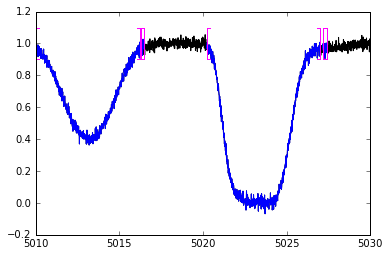

In [76]:
pylab.plot(wavelength_array, flux_array, c='black')

for arr in region_arrays:
    pylab.plot(arr[0], arr[1], color='blue')

for (start, end) in region_pixels:
    plot_bracket(wavelength_array[start], 'left')
    plot_bracket(wavelength_array[end], 'right')
    
pylab.show()

## Finding the right number of profiles

In a complicated spectrum, knowing how many components there are can be difficult. `VPfits` can perform model selection on two fits with different numbers of profiles to determine which is the best.

Below is an early implementation using the Bayesian Information Criterion (BIC) as a threshold.

n:  2
Fit 1 BIC:  -3123.60592039 , Fit 2 BIC:  -3104.42437964
Fit 1 CSL 0.391011140983 | Fit 2 CS: 0.390930930975
BIC Ratio:  1.00617877532
n (final):  1
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 3.8 sec
Took: 0:00:03.766825  to finish.
2 627


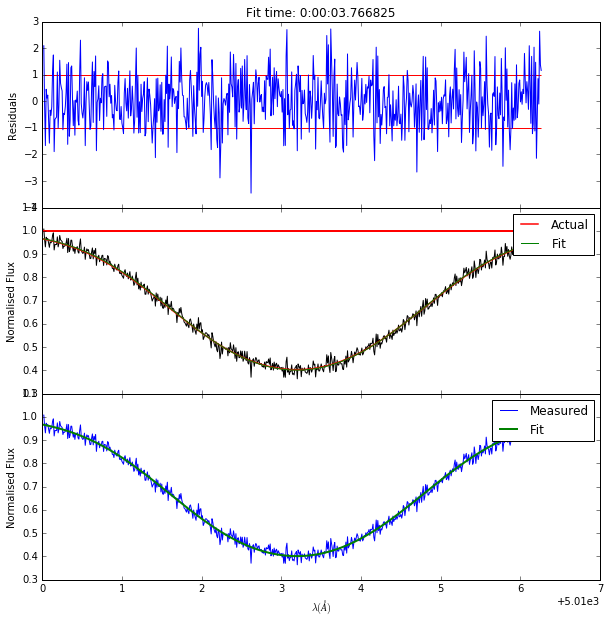

n:  2
Fit 1 BIC:  -95.9321433589 , Fit 2 BIC:  -89.022888584
Fit 1 CSL 0.0156463052381 | Fit 2 CS: 0.0140932395417
BIC Ratio:  1.07761211622
n (final):  1
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 2.0 sec
Took: 0:00:01.962574  to finish.
621 645


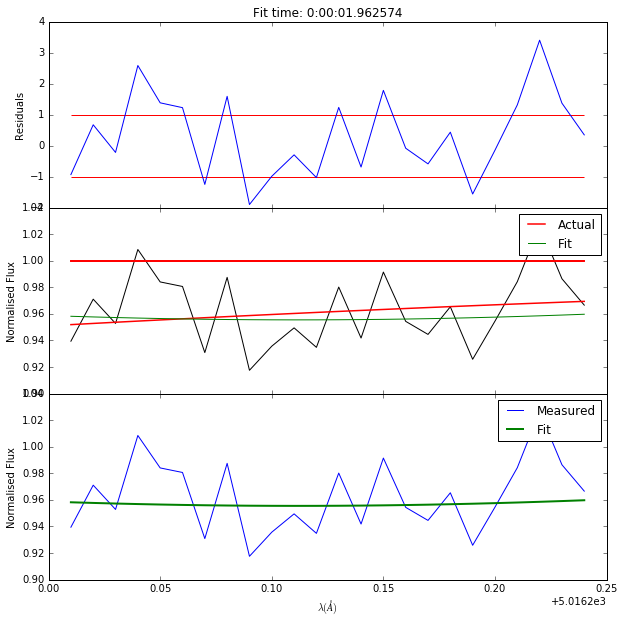

n:  2
Fit 1 BIC:  -2762.62782137 , Fit 2 BIC:  -2743.99977351
Fit 1 CSL 1.72535025802 | Fit 2 CS: 2.25619308482
BIC Ratio:  1.00678864774
n (final):  1
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 4.7 sec
Took: 0:00:04.723546  to finish.
1022 1701


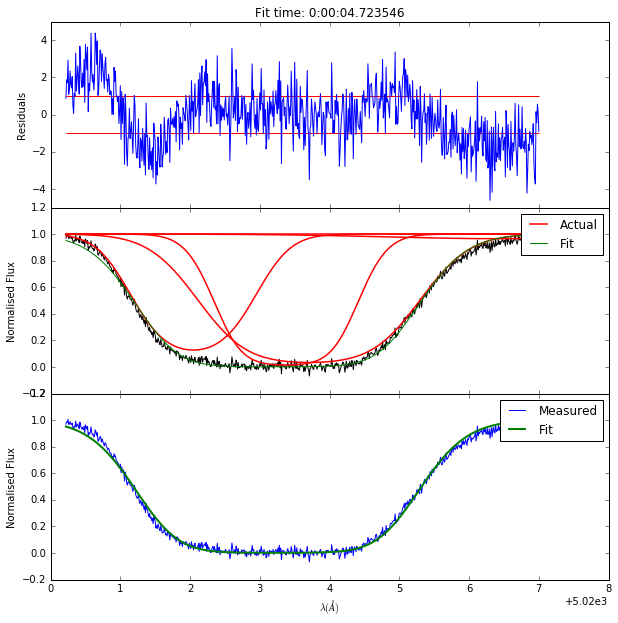

n:  2
Fit 1 BIC:  -95.8487238337 , Fit 2 BIC:  -85.1437812718
Fit 1 CSL 0.0127581102378 | Fit 2 CS: 0.0133017864963
BIC Ratio:  1.12572782653
n (final):  1
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 2.0 sec
Took: 0:00:01.996248  to finish.
1716 1739


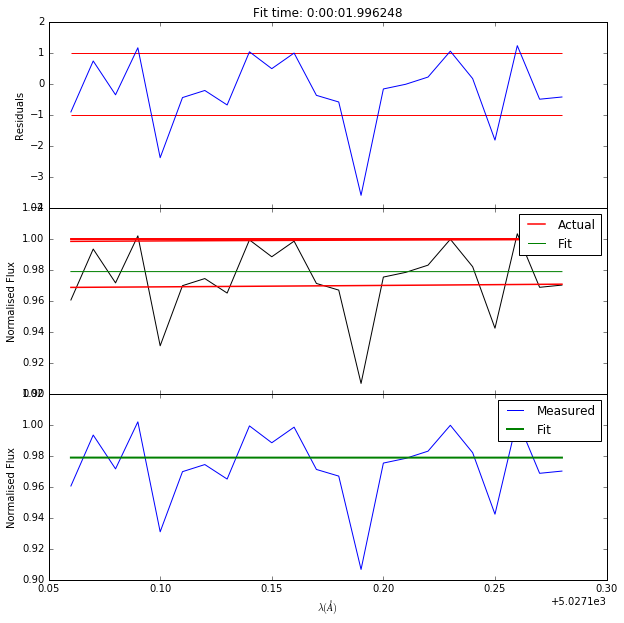

In [77]:
fits = []

for i in range(len(region_arrays)):
    wavelengths = region_arrays[i][0]
    fluxes = region_arrays[i][1]
    
    r = 0
    n = 1
    vpfit_2 = vpfits.VPfit()
    vpfit_2.initialise_model(wavelengths, fluxes, n)
    vpfit_2.map_estimate()

    while r < 1:

        n += 1
        print "n: ", n

        vpfit_1 = vpfit_2

        vpfit_2 = vpfits.VPfit()
        vpfit_2.initialise_model(wavelengths, fluxes, n)
        vpfit_2.map_estimate()

        print "Fit 1 BIC: ", vpfit_1.MAP.BIC, ", Fit 2 BIC: ", vpfit_2.MAP.BIC
        
        print "Fit 1 CSL", vpfits.VPfit.Chisquared(vpfit_1.total.value, fluxes), "| Fit 2 CS:", \
            vpfits.VPfit.Chisquared(vpfit_2.total.value, fluxes)
            
        print "BIC Ratio: ", vpfit_1.MAP.BIC / vpfit_2.MAP.BIC

        r = vpfit_1.MAP.BIC / vpfit_2.MAP.BIC
    
    n -= 1
    print "n (final): ", n
    vpfit_1.mcmc_fit()
    
    fits.append(vpfit_1)
    
    start = region_pixels[i][0]
    end = region_pixels[i][1]
    
    print start, end
    
    vpfit_1.plot(wavelengths, fluxes, clouds, n, start_pix=start, end_pix=end)

Finally, we can plot the detection regions and the fitted profiles over the entire spectrum.

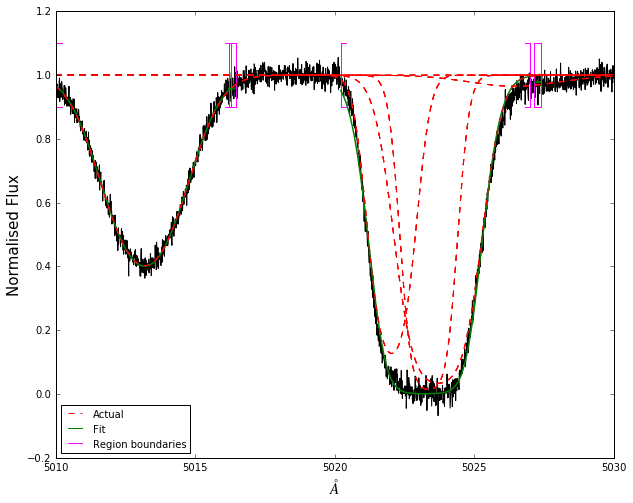

In [79]:
fig, ax = pylab.subplots(figsize=(10,8))

ax.plot(wavelength_array, flux_array, c='black')

for (start, end) in region_pixels:
    plot_bracket(wavelength_array[start], 'left')
    plot_bracket(wavelength_array[end], 'right')

for i in range(len(fits)):
    fit = fits[i]
    wavelengths = region_arrays[i][0]
    fluxes = region_arrays[i][1]
    
    for c in range(len(clouds)):
        ax.plot(wavelength_array, fit.Absorption(clouds.ix[c]['tau']), color="red", ls='--')
        
    for prof in fit.estimated_profiles:
        ax.plot(wavelengths, fit.Absorption(prof.value), color='green', lw=1.5)
        

handles = [mlines.Line2D([], [], color='red', label='Actual', ls='--'), mlines.Line2D([], [], color='green', label='Fit'),
          mlines.Line2D([], [], color='magenta', label='Region boundaries')]

ax.legend(handles=handles, prop={'size':10}, loc='best')

ax.set_xlabel('$\AA$', size=15)
ax.set_ylabel('Normalised Flux', size=15)